In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import get_window
from smstools.models import hpsModel as HPS
from smstools.transformations import hpsTransformations as HPST
from smstools.transformations import harmonicTransformations as HT
from smstools.models import utilFunctions as UF


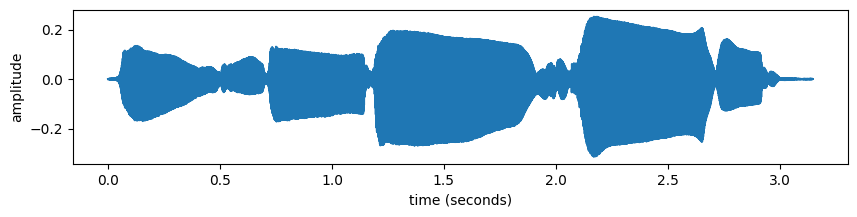

In [2]:
inputFile = "../sounds/sax-phrase-short.wav"
fs, x = UF.wavread(inputFile)
plt.figure(0, figsize=(10, 2))
time_indexes = np.linspace(0, x.size/fs, x.size)
plt.plot(time_indexes, x)
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.show()
ipd.display(ipd.Audio(data=x, rate=fs))

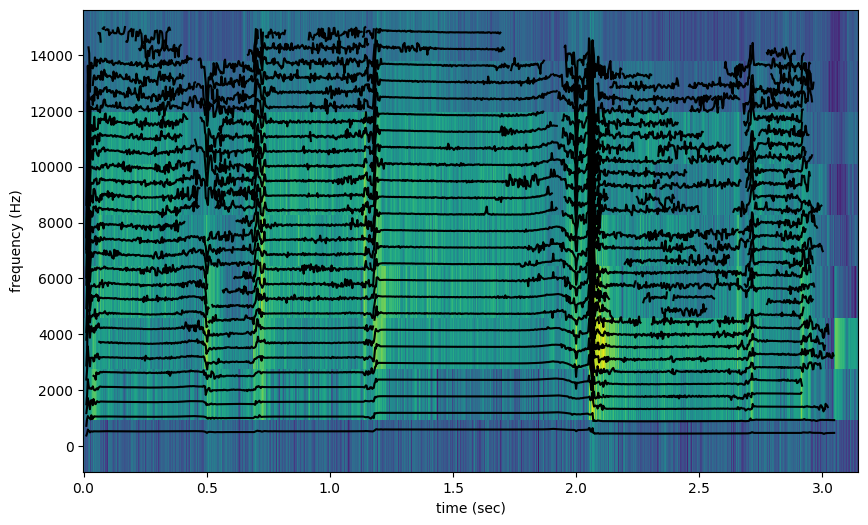

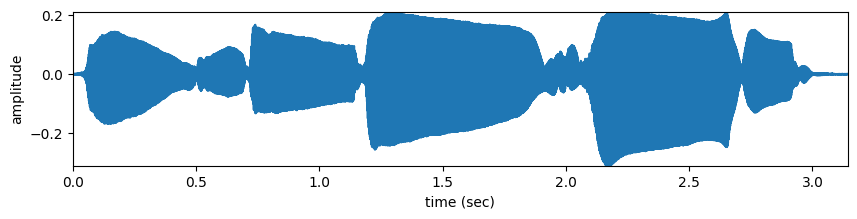

In [3]:
window="blackman"
M=601
N=1024
t=-100
minSineDur=0.1
nH=100
minf0=350
maxf0=700
f0et=5
harmDevSlope=0.01
stocf=0.1

# size of fft used in synthesis
Ns = 512
# hop size (has to be 1/4 of Ns)
H = 128
# compute analysis window
w = get_window(window, M)

# compute the harmonic plus stochastic model of the whole sound
hfreq, hmag, hphase, mYst = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
# synthesize the harmonic plus stochastic model without original phases
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, np.array([]), mYst, Ns, H, fs)

# create figure to plot
plt.figure(figsize=(10, 6))
# frequency range to plot
maxplotfreq = 15000.0

# plot spectrogram stochastic compoment
numFrames = int(mYst[:, 0].size)
sizeEnv = int(mYst[0, :].size)
frmTime = H * np.arange(numFrames) / float(fs)
binFreq = (0.5 * fs) * np.arange(sizeEnv * maxplotfreq / (0.5 * fs)) / sizeEnv
plt.pcolormesh(frmTime, binFreq, np.transpose(mYst[:, : int(sizeEnv * maxplotfreq / (0.5 * fs)) + 1]))
plt.autoscale(tight=True)
# plot harmonic on top of stochastic spectrogram
harms = hfreq * np.less(hfreq, maxplotfreq)
harms[harms == 0] = np.nan
numFrames = int(harms[:, 0].size)
frmTime = H * np.arange(numFrames) / float(fs)
plt.plot(frmTime, harms, color="k", ms=3, alpha=1)
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.autoscale(tight=True)
plt.show()

# plot the output sound
plt.figure(figsize=(10, 2))
plt.plot(np.arange(y.size) / float(fs), y)
plt.axis([0, y.size / float(fs), min(y), max(y)])
plt.ylabel("amplitude")
plt.xlabel("time (sec)")
plt.show()


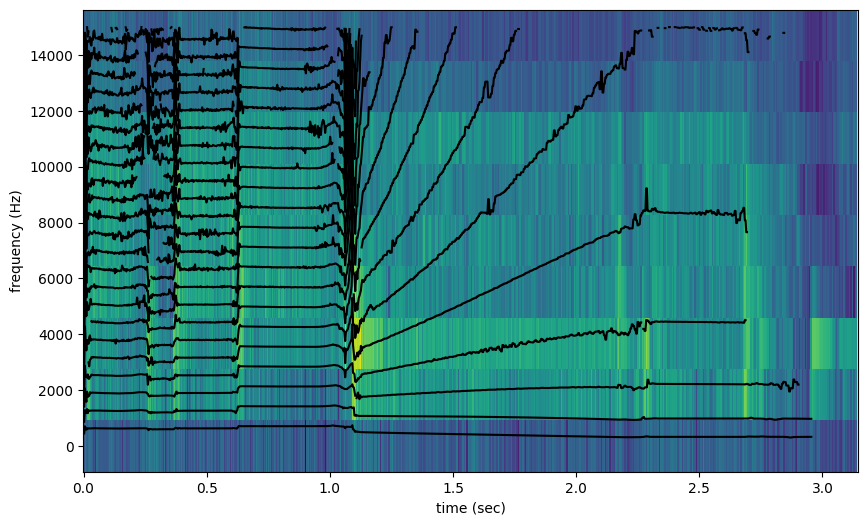

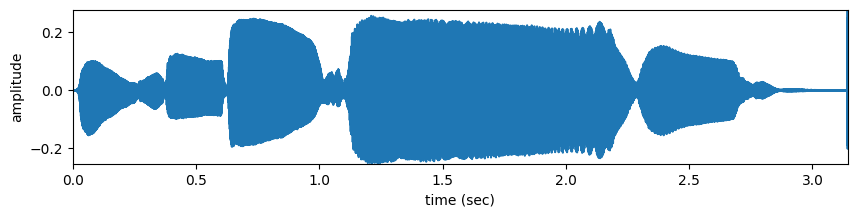

In [5]:
freqScaling=np.array([0, 1.2, 2.01, 1.2, 2.679, 0.7, 3.146, 0.7])
freqStretching=np.array([0, 1, 2.01, 1, 2.679, 1.5, 3.146, 1.5])
timbrePreservation=1
timeScaling=np.array([0, 0, 2.138, 2.138 - 1.0, 3.146, 3.146])

# size of fft used in synthesis
Ns = 512
# hop size (has to be 1/4 of Ns)
H = 128

# frequency scaling of the harmonics
hfreqt, hmagt = HT.harmonicFreqScaling(hfreq, hmag, freqScaling, freqStretching, timbrePreservation, fs)
# time scaling the sound
yhfreq, yhmag, ystocEnv = HPST.hpsTimeScale(hfreqt, hmagt, mYst, timeScaling)
# synthesis from the trasformed hps representation
y, yh, yst = HPS.hpsModelSynth(yhfreq, yhmag, np.array([]), ystocEnv, Ns, H, fs)

# create figure to plot
plt.figure(figsize=(10, 6))
# frequency range to plot
maxplotfreq = 15000.0
# plot spectrogram of transformed stochastic compoment
numFrames = int(ystocEnv[:, 0].size)
sizeEnv = int(ystocEnv[0, :].size)
frmTime = H * np.arange(numFrames) / float(fs)
binFreq = (0.5 * fs) * np.arange(sizeEnv * maxplotfreq / (0.5 * fs)) / sizeEnv
plt.pcolormesh(frmTime, binFreq, np.transpose(ystocEnv[:, : int(sizeEnv * maxplotfreq / (0.5 * fs)) + 1]),)
plt.autoscale(tight=True)
# plot transformed harmonic on top of stochastic spectrogram
harms = yhfreq * np.less(yhfreq, maxplotfreq)
harms[harms == 0] = np.nan
numFrames = int(harms[:, 0].size)
frmTime = H * np.arange(numFrames) / float(fs)
plt.plot(frmTime, harms, color="k", ms=3, alpha=1)
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.autoscale(tight=True)
plt.show()


# plot the output sound
plt.figure(figsize=(10, 2))
plt.plot(np.arange(y.size) / float(fs), y)
plt.axis([0, y.size / float(fs), min(y), max(y)])
plt.ylabel("amplitude")
plt.xlabel("time (sec)")
plt.show()
ipd.display(ipd.Audio(data=y, rate=fs))